In [1]:
import sys
sys.path.append('../')
sys.path.append('../Nets/')
from glob import glob
from os.path import join, isfile, basename
import pickle
from multiprocessing import Pool
from scipy.ndimage.interpolation import rotate
from keras.optimizers import adam
from tqdm import tqdm
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from functools import partial
import seaborn as sns
import time
from NoduleClfOld import *
import pandas as pd
import csv
from paths import *
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [11]:
CPU = 24
LOWER = -1000
UPPER = 400
BATCH_SIZE = 100
ITERATIONS = 80
SHAPE = (18, 48, 48)

In [12]:
def augment_patch(patch, shape, shift=4):
    center = (array(patch.shape) // 2) 
    
    left = array(shape) // 2
    right = array(shape) - left
    
    patch = [patch[center[0] - left[(0 + i) % 3]:center[0] + right[(0 + i) % 3], 
                   center[1] - left[(1 + i) % 3]:center[1] + right[(1 + i) % 3], 
                   center[2] - left[(2 + i) % 3]:center[2] + right[(2 + i) % 3]] for i in range(3)]
    
    patch[1] = swapaxes(patch[1], 0, 2)
    patch[2] = swapaxes(patch[2], 0, 1)
    patch = [expand_dims(array(patch[i]), -1)  
             for i in range(3)]
    patch = clip(patch, LOWER, UPPER) 
    patch = (patch - LOWER) / float(UPPER - LOWER) 
    return patch

In [41]:
def batch_generator(batch_files, 
                    shape=(18, 48, 48), 
                    CPU=24):
    
    with Pool(CPU) as pool:
        patch_list = pool.map(load, batch_files) 

    augment = partial(augment_patch, 
                      shape=shape)

    with Pool(CPU) as pool:
        patch_list = pool.map(augment, patch_list)
    
    return [patch for patch in swapaxes(asarray(patch_list), 0, 1)]

In [21]:
data = pd.read_csv(join(PATH['DATA_OUT'], 'DATAFRAMES', 'top_patches'))
data['patientid'] = data.patchid.apply(lambda x: x[:32])
train = data.merge(pd.read_csv(PATH['LABELS']), 
                   left_on='patientid', 
                   right_on='id').drop(['patientid'], axis=1)

In [6]:
clf_model, coders, bottle_neck = predictor(dropout_conv=.2, 
                                           dropout_dence=.3, 
                                           shape=(18, 48, 48, 1),
                                           shared_layers=True
                                          )

clf_model.compile('adam', 'categorical_crossentropy')
clf_model.load_weights(join(PATH['WEIGHTS'], '3DCNN_nodule_clf_shared_tested'))

In [13]:
def operate(file_list):
    epoch = BATCH_SIZE * ITERATIONS
    overall = int(ceil(len(file_list) / epoch))
    for counter in tqdm(range(overall)):
        batch_files = file_list[epoch * counter:
                                epoch * (counter + 1)]
        batch_data = batch_generator(batch_files)
        batch_data = clf_model.predict(batch_data, BATCH_SIZE)
        fd_name = join(PATH['ENHANCED_PREDICTED'], 'predicted_' + str(counter) + '.csv')
        pd.DataFrame({'patchid': [basename(name) 
                                  for name in batch_files], 
                      'probability': batch_data[0][:, 0], 
                      'dence': [data 
                                for data in batch_data[1]]}).to_csv(fd_name, 
                                                                    index=False)

In [ ]:
# file_list = get_remind_files()
operate(file_list)

100%|██████████| 113/113 [9:57:00<00:00, 242.29s/it]


In [7]:
a = load(join(PATH['DATA_OUT'], '820cc2a44d87d9b3798782f7cc6f2a74.npy'))

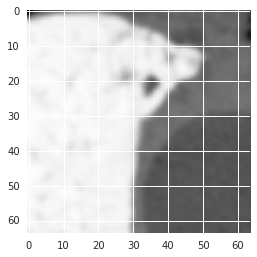

In [11]:
rint = random.randint(0, len(file_list))
im = load(file_list.values[rint])
imshow(im[im.shape[0] // 2])

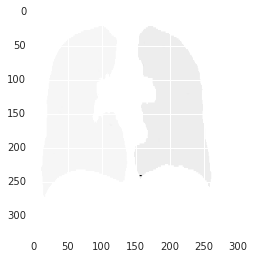

In [9]:
imshow(flipud(a)[:, a.shape[1] // 2])